In [453]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import pickle
import warnings
warnings.filterwarnings('ignore')

In [454]:
with open('subscribers', 'rb') as f:
    subs = pickle.load(f)
with open('customer_service_reps', 'rb') as f:
    customer_service_reps = pickle.load(f)
with open('engagement', 'rb') as f:
    eng = pickle.load(f)

In [455]:
subs.head()

,subid,package_type,num_weekly_services_utilized,preferred_genre,intended_use,weekly_consumption_hour,num_ideal_streaming_services,retarget_TF,age,male_TF,...,creation_until_cancel_days,cancel_before_trial_end,trial_end_date,initial_credit_card_declined,revenue_net,join_fee,language,paid_TF,refund_after_trial_TF,payment_type
162502,21724479,economy,NaN,comedy,access to exclusive content,NaN,NaN,False,NaN,False,...,NaN,True,2020-02-08,False,NaN,NaN,ar,True,False,Standard Charter
380374,23383224,base,NaN,comedy,access to exclusive content,22.951579,NaN,False,70.0,False,...,0.0,False,2020-03-16,False,0.0,0.3303,ar,False,False,NaN
496617,26844789,enhanced,3.362885,regional,replace OTT,36.001186,1.951776,False,25.0,True,...,1.0,False,2019-12-22,False,0.0,0.1101,ar,False,False,NaN
356799,29417030,base,NaN,drama,replace OTT,20.051667,NaN,False,30.0,False,...,0.0,False,2020-02-11,False,0.0,0.0367,ar,False,False,NaN
681701,26723159,base,3.731089,comedy,replace OTT,22.951579,2.506384,False,28.0,False,...,9.0,False,2019-10-20,False,0.0,0.0367,ar,False,False,NaN


In [456]:
subs = subs.reset_index(drop=True)

In [457]:
eng.head()

,subid,date,app_opens,cust_service_mssgs,num_videos_completed,num_videos_more_than_30_seconds,num_videos_rated,num_series_started,payment_period
1,22349235,2019-07-01,1.0,1.0,0.0,6.0,0.0,0.0,0.0
2,22349235,2019-07-02,1.0,0.0,0.0,5.0,0.0,0.0,0.0
3,22349235,2019-07-03,0.0,1.0,0.0,0.0,0.0,0.0,0.0
50,20848497,2019-07-02,1.0,0.0,7.0,7.0,0.0,0.0,0.0
51,22680106,2019-07-02,2.0,1.0,7.0,7.0,0.0,1.0,0.0


In [458]:
customer_service_reps.head()

,customer_service_rep_id,subid,current_sub_TF,cancel_date,account_creation_date,num_trial_days,trial_completed_TF,billing_channel,revenue_net_1month,payment_period,last_payment,next_payment,renew
4,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,0,2019-11-26 03:30:29,2019-11-26 03:30:29,NaN
5,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,1,2019-11-26 03:30:29,2019-12-27 03:30:29,NaN
6,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,2,2019-12-27 03:30:29,2020-01-26 03:30:29,NaN
7,36189811,25108574,False,NaT,2019-11-26 03:30:29,7,True,itunes,1.1377,3,2020-01-26 03:30:29,NaT,NaN
8,31174901,25914865,True,NaT,2020-03-19 01:20:25,14,True,itunes,1.1377,0,2020-03-19 01:20:25,2020-04-02 01:20:25,NaN


In [459]:
subs.columns

Index(['subid', 'package_type', 'num_weekly_services_utilized',
       'preferred_genre', 'intended_use', 'weekly_consumption_hour',
       'num_ideal_streaming_services', 'retarget_TF', 'age', 'male_TF',
       'country', 'attribution_technical', 'attribution_survey', 'op_sys',
       'months_per_bill_period', 'plan_type', 'monthly_price',
       'discount_price', 'account_creation_date', 'creation_until_cancel_days',
       'cancel_before_trial_end', 'trial_end_date',
       'initial_credit_card_declined', 'revenue_net', 'join_fee', 'language',
       'paid_TF', 'refund_after_trial_TF', 'payment_type'],
      dtype='object')

## Data preprocessing

In [460]:
# define conversion

for i in range(len(subs)):
    if (subs.loc[i,'paid_TF'] == True and subs.loc[i,'refund_after_trial_TF'] == False):
        subs.loc[i,'convert_TF'] = True
    else:
        subs.loc[i,'convert_TF'] = False

## A/B test on plan type

In [461]:
subs.plan_type.value_counts()

base_uae_14_day_trial                227096
high_uae_14_day_trial                   325
low_uae_no_trial                        167
base_eur_14_day_trial                    18
high_sar_14_day_trial                    12
low_gbp_14_day_trial                      4
high_aud_14_day_trial                     2
low_eur_no_trial                          1
base_uae_no_trial_7_day_guarantee         1
low_sar_no_trial                          1
high_jpy_14_day_trial                     1
Name: plan_type, dtype: int64

In [462]:
def calc_proportion(array_TF):
    return sum(array_TF)/len(array_TF)


def calc_zscore(phat, p, n_f):
    return (phat-p)/np.sqrt(p*(1-p)/n_f)


def get_z_crit_value(alpha_f, num_sides_f):
    return norm.ppf(1-(alpha_f/num_sides_f))


def get_p_value(zscore_f, num_sides_f):
    return (1-norm.cdf(abs(zscore_f))) * num_sides_f


def reject_null(variantA_outcomes_f, variantB_outcomes_f, alpha_f, num_sides_f):
    p_hat_f = calc_proportion(variantB_outcomes_f)
    p_f = calc_proportion(variantA_outcomes_f)
    n_f = len(variantB_outcomes_f)
    z_score = calc_zscore(p_hat_f, p_f, n_f)
    p_value = get_p_value(z_score, num_sides_f)
    z_crit = get_z_crit_value(alpha_f, num_sides_f)
    return z_score > z_crit, z_score, p_value


In [463]:
# set test parameter: 95% confidence level, one-tailed test

alpha_f = .05
num_sides_f = 1

In [464]:
AB_test = pd.DataFrame(index = ["conversion_rate","reject","z_score","p_value"], \
                        columns=['base_uae_14_day_trial','high_uae_14_day_trial','low_uae_no_trial'])

In [465]:
plan_type = ['base_uae_14_day_trial','high_uae_14_day_trial','low_uae_no_trial']

for i in range(len(plan_type)):
    variantA_base_uae_14 = subs.loc[(subs['plan_type'] == 'base_uae_14_day_trial'),'convert_TF']
    variantB = subs.loc[(subs['plan_type'] == plan_type[i]),'convert_TF']
    reject_null_test, z_score, p_value = reject_null(variantA_base_uae_14, variantB, alpha_f, num_sides_f)
    
    AB_test.at["conversion_rate",plan_type[i]] = round(calc_proportion(variantB),4)
    AB_test.at["reject",plan_type[i]] = reject_null_test
    AB_test.at["z_score",plan_type[i]] = z_score
    AB_test.at["p_value",plan_type[i]] = p_value

In [466]:
AB_test

,base_uae_14_day_trial,high_uae_14_day_trial,low_uae_no_trial
conversion_rate,0.3635,0.2985,0.7964
reject,False,False,True
z_score,0.0,-2.438955,11.629309
p_value,0.5,0.007365,0.0


## Attribution & Allocation

In [467]:
df = pd.DataFrame()

In [468]:
df['subid'] = subs.subid

In [470]:
df['convert_TF'] = subs.convert_TF

In [472]:
df['touch'] = subs.attribution_technical

In [473]:
#seperate customer fraction by they internet package type

tier = {
    'economy':3,
    'base':2,
    'enhanced':1
}

In [474]:
df['tier'] = subs.package_type
df['tier'] = df['tier'].map(tier)

In [506]:
df.head()

,subid,convert_TF,touch,tier
0,21724479,True,facebook,3.0
1,23383224,False,facebook,2.0
2,26844789,False,organic,1.0
3,29417030,False,search,2.0
4,26723159,False,discovery,2.0


In [476]:
df_spending = pd.read_csv('Copy of channel_spend_graduate.csv')

In [477]:
#conversion rate for each tier

percentage1 = len(df[df.tier == 1][df.convert_TF == True]) / len(df[df.tier == 1])
print(percentage1)
percentage2 = len(df[df.tier == 2][df.convert_TF == True]) / len(df[df.tier == 2])
print(percentage2)
percentage3 = len(df[df.tier == 3][df.convert_TF == True]) / len(df[df.tier == 3])
print(percentage3)

0.326781676444079
0.3751166295844398
0.38837973370223067


In [478]:
df.tier.value_counts()

2.0    111464
1.0     63241
3.0     17349
Name: tier, dtype: int64

In [479]:
total_spending = pd.DataFrame(index=df_spending.channel.unique())

In [480]:
total_spending['total_spending'] = df_spending.groupby(by='channel')['spend_AED'].sum()

In [483]:
#calculate avg. CAC for the top 5 channels.

CAC_bing = total_spending.at['bing','total_spending'] / len(df[df.convert_TF == True][df.touch == 'bing'])
print('bing: %.2f'%CAC_bing)
CAC_display = total_spending.at['display','total_spending'] / len(df[df.convert_TF == True][df.touch == 'display'])
print('display: %.2f'%CAC_display)
CAC_facebook = total_spending.at['facebook','total_spending'] / len(df[df.convert_TF == True][df.touch == 'facebook'])
print('facebook: %.2f'%CAC_facebook)
CAC_search = total_spending.at['search','total_spending'] / len(df[df.convert_TF == True][df.touch == 'search'])
print('search: %.2f'%CAC_search)
CAC_youtube = total_spending.at['youtube','total_spending'] / len(df[df.convert_TF == True][df.touch == 'youtube'])
print('youtube: %.2f'%CAC_youtube)

bing: 28.42
display: 0.70
facebook: 4.32
search: 27.49
youtube: 38.29


In [484]:
df['touch'].value_counts()

facebook                   80251
email                      25690
search                     25306
organic                    22013
brand sem intent google    18524
google_organic             10691
affiliate                   9894
email_blast                 7277
pinterest                   6065
referral                    5170
facebook_organic            3272
discovery                   2571
brand sem intent bing       2231
other                       1786
display                     1407
bing                        1146
internal                    1122
podcast                      985
youtube                      913
bing_organic                 369
vod                          297
ott                          158
direct_mail                  139
quora                        100
samsung                       86
appstore                      44
criteo                        44
pinterest_organic             30
influencer                    21
playstore                     12
content_gr

In [485]:
# calculate marginal CAC

for a in ['bing', 'facebook', 'display', 'search', 'youtube']:
    economic_cac = 3000 / df.touch[df.tier == 3][df.touch==a].count()
    ehance_cac = 3000 / (df.touch[df.tier == 1][df.touch==a].count() - df.touch[df.tier == 3][df.touch==a].count())
    based_cac = 3000 / (df.touch[df.tier == 2][df.touch==a].count() - df.touch[df.tier == 1][df.touch==a].count())
    print(a, economic_cac, ehance_cac, based_cac)

bing 27.027027027027028 15.151515151515152 10.989010989010989
facebook 0.5347593582887701 0.18858436007040483 0.16756968105904038
display 21.8978102189781 10.60070671378092 8.571428571428571
search 1.7772511848341233 0.3831417624521073 1.122754491017964
youtube 38.46153846153846 12.5 16.304347826086957


## Churn

In [487]:
subs_churn = subs.copy()

In [488]:
subs_churn['convert_TF'] = df.convert_TF

In [489]:
subs_churn.columns

Index(['subid', 'package_type', 'num_weekly_services_utilized',
       'preferred_genre', 'intended_use', 'weekly_consumption_hour',
       'num_ideal_streaming_services', 'retarget_TF', 'age', 'male_TF',
       'country', 'attribution_technical', 'attribution_survey', 'op_sys',
       'months_per_bill_period', 'plan_type', 'monthly_price',
       'discount_price', 'account_creation_date', 'creation_until_cancel_days',
       'cancel_before_trial_end', 'trial_end_date',
       'initial_credit_card_declined', 'revenue_net', 'join_fee', 'language',
       'paid_TF', 'refund_after_trial_TF', 'payment_type', 'convert_TF'],
      dtype='object')

In [490]:
subs_churn.describe()

,subid,num_weekly_services_utilized,weekly_consumption_hour,num_ideal_streaming_services,age,months_per_bill_period,monthly_price,discount_price,creation_until_cancel_days,revenue_net,join_fee
count,2.276280e+05,117178.000000,189698.000000,115458.000000,1.924590e+05,227628.0,227628.000000,227628.000000,151768.000000,192724.000000,192724.000000
mean,2.498624e+07,2.998568,27.997724,1.999848,7.579755e+02,4.0,4.732049,4.512188,16.570832,1.557353,0.115145
std,2.885543e+06,0.748752,4.976341,0.249508,1.920204e+05,0.0,0.101049,0.097078,35.777986,3.068829,0.176971
min,2.000001e+07,0.049049,-32.146760,-0.919933,0.000000e+00,4.0,0.807400,0.770700,-108.000000,-5.982100,-0.660600
25%,2.248998e+07,2.493926,24.401536,1.867354,3.500000e+01,4.0,4.734300,4.514100,2.000000,0.000000,0.036700
50%,2.497011e+07,2.760506,27.301448,1.908159,4.600000e+01,4.0,4.734300,4.514100,8.000000,0.000000,0.036700
75%,2.749020e+07,3.271574,30.201361,1.953559,5.700000e+01,4.0,4.734300,4.514100,13.000000,2.532300,0.110100
max,2.999998e+07,14.335378,76.599962,6.955714,8.172000e+07,4.0,5.101300,5.027900,312.000000,15.634200,0.734000


In [491]:
# replace the negative values in weekly_consumption_hour and num_ideal_streaming_services with means, since they are
# self-reported and might be randomly filled, no matter intentionally or unintentionally.
subs_churn['weekly_consumption_hour'][subs_churn['weekly_consumption_hour']<0] = \
subs_churn['weekly_consumption_hour'].mean()
subs_churn['num_ideal_streaming_services'][subs_churn['num_ideal_streaming_services']<0] = \
subs_churn['num_ideal_streaming_services'].mean()

# drop those data with ages greater than 70, which are filled in randomly and might be noise to prediciton.
subs_churn.drop(subs_churn[subs_churn["age"]>70].index,inplace=True)

# drop irrevelent columns
subs_churn.drop(['monthly_price','discount_price','months_per_bill_period','account_creation_date'
                 ,'creation_until_cancel_days','cancel_before_trial_end','initial_credit_card_declined','revenue_net'
                ,'paid_TF','refund_after_trial_TF','payment_type','trial_end_date'],axis=1,inplace=True)

In [492]:
subs_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219725 entries, 0 to 227627
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   subid                         219725 non-null  int64  
 1   package_type                  185464 non-null  object 
 2   num_weekly_services_utilized  113524 non-null  float64
 3   preferred_genre               184766 non-null  object 
 4   intended_use                  216354 non-null  object 
 5   weekly_consumption_hour       181916 non-null  float64
 6   num_ideal_streaming_services  111885 non-null  float64
 7   retarget_TF                   219725 non-null  bool   
 8   age                           184556 non-null  float64
 9   male_TF                       219456 non-null  object 
 10  country                       219725 non-null  object 
 11  attribution_technical         219725 non-null  object 
 12  attribution_survey            217215 non-nul

In [493]:
# splitting data to do churn prediction by decission tree model

from sklearn.model_selection import train_test_split

df_train,df_test = train_test_split(subs_churn,test_size = 0.2, random_state = 111)

y_train = (df_train.convert_TF).values
y_test = (df_test.convert_TF).values

In [494]:
del df_train['convert_TF']
del df_test['convert_TF']

In [495]:
# one-hot encoding
from sklearn.feature_extraction import DictVectorizer
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

dict_train = df_train.to_dict(orient='records')
dict_val = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

In [496]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train.astype(int))

DecisionTreeClassifier()

In [497]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_test.astype(int), y_pred)

0.7164879926762406

In [498]:
# Tuning the model

for m in [4, 5, 6,10]:
    print('depth: %s' % m)

    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train.astype(int))
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_test.astype(int), y_pred)
        print('%s -> %.3f' % (s, auc))
    
    print()

depth: 4
1 -> 0.826
5 -> 0.826
10 -> 0.827
15 -> 0.827
20 -> 0.827
50 -> 0.827
100 -> 0.827
200 -> 0.827

depth: 5
1 -> 0.839
5 -> 0.839
10 -> 0.839
15 -> 0.839
20 -> 0.839
50 -> 0.840
100 -> 0.840
200 -> 0.839

depth: 6
1 -> 0.851
5 -> 0.851
10 -> 0.851
15 -> 0.851
20 -> 0.851
50 -> 0.851
100 -> 0.851
200 -> 0.851

depth: 10
1 -> 0.862
5 -> 0.863
10 -> 0.864
15 -> 0.864
20 -> 0.864
50 -> 0.864
100 -> 0.865
200 -> 0.864



In [499]:
# Determine the hyperparameter

dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=100)
dt.fit(X_train, y_train.astype(int))

y_pred_dt = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_test.astype(int), y_pred_dt)

0.86511851066771

In [500]:
# ------ DEFINE FUNCTIONS -----
def apply_offers(df, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn):
    df_f = df_test.copy()

    # set offer parameters for all observations
    df_f['price_no_offer'] = base_price
    df_f.loc[df_f['convert_TF'] == False, 'price_no_offer'] = 0  # if the person churns they will pay 0

    # determine whether indiviudals accept offer
    df_f.loc[df_f['convert_TF'] == False, 'accept_offer_prob'] = acceptance_rate_churn  # those who were going to churn are less likely to want the offer than those who were going to stay
    df_f.loc[df_f['convert_TF'] == True, 'accept_offer_prob'] = acceptance_rate_nonchurn
    df_f['would_accept_offer_rand_draw'] = (df_f['random_draws'] < df_f['accept_offer_prob'])  # randomly select the individuals who would accept an offer based on their probability of acceptance

    # make offer under predictions for select threshold
    df_f['make_offer'] = (df_f['prob_churn'] > threshold)     # predict whether individual will churn or not
    df_f['accept_offer'] = (df_f['make_offer'] & df_f['would_accept_offer_rand_draw'])
    df_f['price_offer'] = df_f['price_no_offer']  # initialize prices from "do nothing case"
    df_f.loc[df_f['accept_offer'], 'price_offer'] = base_price * (1-discount_amount)    # for those who were both made an offer and would accept, set prices to discounted price

    df_impact = pd.DataFrame(index=cases, columns=['subs', 'revenue', 'lift_from_no_offer'])
    for c in cases:
        df_impact.loc[c, 'subs'] = (df_f['price_' + c] > 0).sum() # 
        df_impact.loc[c, 'revenue'] = df_f['price_' + c].sum()
    for c in cases:
        df_impact.loc[c, 'lift_from_no_offer'] = df_impact.loc[c, 'revenue'] / df_impact.loc['no_offer', 'revenue'] - 1

    return df_f, df_impact


In [501]:
# ----- TEST RETENTION OFFER SCENARIOS -----
# evaluate the impact of an offer
acceptance_rate_nonchurn = 1
acceptance_rate_churn = 0.3
threshold = 0.5
base_price = 4.7343
discount_amount = 0.3
cases = ['no_offer', 'offer']

# draw whether individual would accept an offer or not - assume probability of acceptance is independent of offer attractiveness
df_test['random_draws'] = np.random.random(df_test.shape[0])


df_test['prob_churn'] = dt.predict_proba(X_val)[:, 0]
df_test['convert_TF'] = y_test.tolist()
# base assessment
df_test, df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

# test sensitivity to thresholds
df_lift_threshold = pd.DataFrame(index=range(0, 100, 1), columns=['threshold'] + cases)
for t_ind in df_lift_threshold.index:
    t_threshold = t_ind / 100
    _, t_df_impact = apply_offers(df_test, t_threshold, base_price, discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_threshold.loc[t_ind, 'threshold'] = t_threshold
    df_lift_threshold.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_threshold, t_ind

# test sensitivity to acceptance rate for churners
df_lift_acceptance_rate_churn = pd.DataFrame(index=range(0, 100, 1), columns=['acceptance_rate_churn'] + cases)
for t_ind in df_lift_acceptance_rate_churn.index:
    t_acceptance_rate_churn = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, discount_amount, cases, t_acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_acceptance_rate_churn.loc[t_ind, 'acceptance_rate_churn'] = t_acceptance_rate_churn
    df_lift_acceptance_rate_churn.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_acceptance_rate_churn, t_ind

# test sensitivity to offer discount amount
df_lift_discount_amount = pd.DataFrame(index=range(0, 100, 1), columns=['discount_amount'] + cases)
for t_ind in df_lift_discount_amount.index:
    t_discount_amount = t_ind / 100
    _, t_df_impact = apply_offers(df_test, threshold, base_price, t_discount_amount, cases, acceptance_rate_churn, acceptance_rate_nonchurn)

    df_lift_discount_amount.loc[t_ind, 'discount_amount'] = t_discount_amount
    df_lift_discount_amount.loc[t_ind, cases] = t_df_impact.loc[cases, 'lift_from_no_offer']
del t_df_impact, t_discount_amount, t_ind



In [502]:
df_impact

,subs,revenue,lift_from_no_offer
no_offer,16012,75805.6116,0.0
offer,23659,92163.09153,0.215782


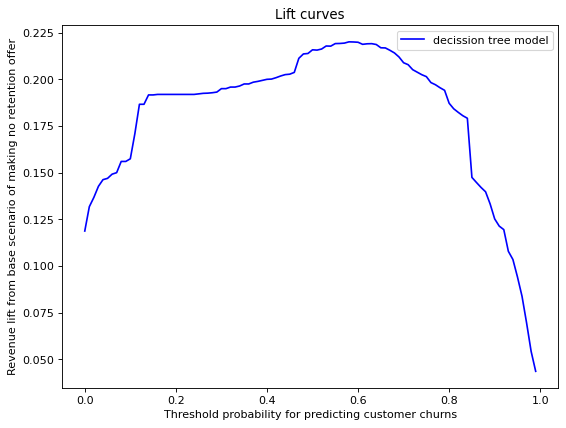

In [503]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8, 6), dpi=80)
ax1 = plt.gca()
ax1.plot(df_lift_threshold['threshold'], df_lift_threshold['offer'], 'b-')
plt.title('Lift curves')
plt.xlabel('Threshold probability for predicting customer churns')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['decission tree model'])


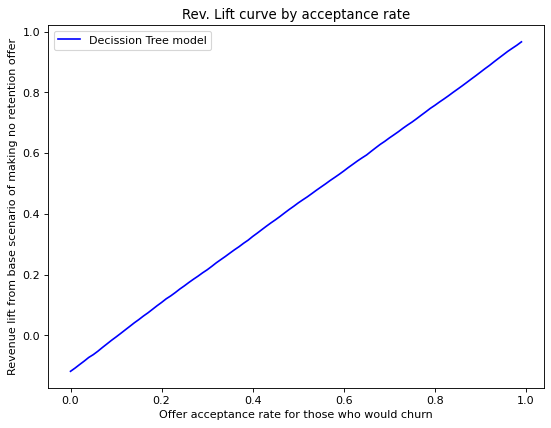

In [504]:
# Acceptance rate sensitivity
fig = plt.figure(figsize=(8, 6), dpi=80)
ax1 = plt.gca()
ax1.plot(df_lift_acceptance_rate_churn['acceptance_rate_churn'], df_lift_acceptance_rate_churn['offer'], 'b-')
plt.title('Rev. Lift curve by acceptance rate')
plt.xlabel('Offer acceptance rate for those who would churn')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Decission Tree model'])


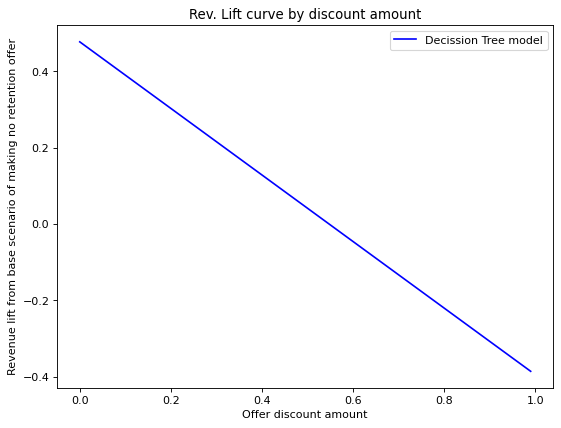

In [505]:
# Discount amount sensitivity
fig = plt.figure(figsize=(8, 6), dpi=80)
ax1 = plt.gca()
ax1.plot(df_lift_discount_amount['discount_amount'], df_lift_discount_amount['offer'], 'b-')
plt.title('Rev. Lift curve by discount amount')
plt.xlabel('Offer discount amount')
plt.ylabel('Revenue lift from base scenario of making no retention offer')
plt.legend(labels=['Decission Tree model'])